In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.widgets import Slider
from boundary import *
import rootfinding as rf
custom_rf = {'tol': 2E-12, 'maxiter': 50,
             'rootfind_open': rf.newton, 'rootfind_bracketing': rf.bisect,
             'param_rootfind': 'bracketing'}

I'll propagate billiards using a generator-iterator ('billiard_propagator_gen') and save billiard state in a dictionary. The state dictionary will hold the propagator, the trajectory as an array of (x,y) coordinates, the boundary collision points as a list of boundary parameters (denoted 's'), a list of the tangential component of velocity ('v_tan') at each collision, and a reference to the boundary object.

In [2]:
def billiard_propagator_gen(r, v, bdy):
    s = bdy.linear_intersect_cart(r, v)
    if np.any(np.sign(bdy.coords_cart(s) - r) != np.sign(v)):
        # Then we found the intercept in the wrong direction! Try again.
        try:
            # the intersect_param method excludes passed root s if
            s = bdy.linear_intersect_param(s, v)
        except RuntimeError as e:
            print e
    while True:
        tangent = bdy.tangent_cart(s)
        v_tan = np.dot(v, tangent)
        yield s, v_tan
        v = 2 * v_tan * tangent - v
        try:
            s = bdy.linear_intersect_param(s, v)
        except RuntimeError as e:
            print e

def init_state(r, v, boundary):
    """Initialize state given i.c.'s, position r and velocity v, for
        the given boundary.
    """
    state = {'s_list': [],
             'v_tan_list': [],
             'trajectory': np.c_[r],
             'propagator': billiard_propagator_gen(r, v, boundary),
             'boundary': boundary}
    return state


def propagate(state, bounces):
    """Update state by a number 'bounces' of collisions.
    """
    new_s, new_v_tan = zip(*(state['propagator'].next()
                             for _ in xrange(int(bounces))))
    state['s_list'].extend(new_s)
    state['v_tan_list'].extend(new_v_tan)
    state['trajectory'] = np.c_[state['trajectory'],
                                state['boundary']\
                                .coords_cart(np.array(new_s))]

I want to be able to play with my plots of trajectories and Poincare sections, so I'll use functions to initialize and update plot data. This allows me to add sliders to relevant figures to control the number of collisions and the deviation from initial conditions of the displayed data.

In [3]:
def propagate_plots(fig, state, n, traj_line=None, poinc_ax=None,
                    clear_poinc_ax=True, **plot_kwargs):
    """Update plots to show 'n' collisions of given state.
    
    Optional: traj_line, the plotline of the trajectory to update;
              poinc_ax, the axis of the Poincare section to update.
    If the state does not know n collisions, first propagate it
     to the necessary number.
    """
    clr = clear_poinc_ax and poinc_ax is not None
    if clr: poinc_ax.clear()
    missing = n+1 - state['trajectory'].shape[1]
    if missing <= 0:
        if traj_line is not None:
            traj_line.set_xdata(state['trajectory'][0, 0:n+1])
            traj_line.set_ydata(state['trajectory'][1, 0:n+1])
        if poinc_ax is not None:
            poinc_ax.scatter(state['s_list'][0:n+1],
                             state['v_tan_list'][0:n+1],
                             **plot_kwargs)
    else:
        propagate(state, missing)   
        if traj_line is not None: 
            traj_line.set_xdata(state['trajectory'][0])
            traj_line.set_ydata(state['trajectory'][1])
        if poinc_ax is not None:
            poinc_ax.scatter(state['s_list'],
                             state['v_tan_list'],
                             **plot_kwargs)
    if clr:
        poinc_ax.set_ylim([-1, 1])
        poinc_ax.set_xlim([0, 2*np.pi])
    fig.canvas.draw()


def reset_plots(fig, r, v, boundary, n, traj_line=None, poinc_ax=None,
                **propagate_plots_kwargs):
    """Reinitialize data for given initial conditions.
    
    Optional: traj_line, the plotline of the trajectory to update;
              poinc_ax, the axis of the Poincare section to update.
    """
    state = init_state(r, v, boundary)
    propagate_plots(fig, state, n, traj_line, poinc_ax,
                    **propagate_plots_kwargs)
    return state


def make_interactive(fig, state, r, v, boundary,
                     default_bounces, max_bounces,
                     default_deltay, max_deltay, rdy_func,
                     traj_line=None, poinc_ax=None,
                     **propagate_plots_kwargs):
    """Add sliders to fig for interactive control of bounces and dy.
    
    Note, sliders do not function if matplotlib is in "inline"
     or "notebook" mode.
    Returns the sliders (sbounces, sdeltay). The sliders will only function
     while these references are held.
    """
    axcolor = 'lightgoldenrodyellow'
    axbounces = fig.add_axes([0.2, 0.03, 0.65, 0.02], facecolor=axcolor)
    sbounces = Slider(axbounces, 'Number of bounces',
                      1, max_bounces, valinit=default_bounces)
    axdeltay = fig.add_axes([0.2, 0.005, 0.65, 0.02], facecolor=axcolor)
    sdeltay = Slider(axdeltay, r'$\Delta y_0$ / $(y_0 * 10^{-8})$',
                     -max_deltay, max_deltay, valinit=default_deltay)
    # Configure our Sliders to update the plotlines.
    # The Sliders will pass their current value to the on_changed event callback
    sbounces.on_changed(lambda val: propagate_plots(fig, state, int(val),
                                                    traj_line, poinc_ax,
                                                    **propagate_plots_kwargs))
    sdeltay.on_changed(lambda val: reset_plots(fig, rdy_func(r, val), v,
                                               boundary, int(sbounces.val),
                                               traj_line, poinc_ax,
                                               **propagate_plots_kwargs))
    return sbounces, sdeltay

I'm interested in comparing trajectories for the Circle and Bean boundaries, so I'll write a function to generate plots to illustrate the differences.

In [4]:
def compare_traj_for_bdys(bdys, bounces, r0, v0):
    """Create side-by-side plots of trajectories with the same i.c.'s
        but different boundarys."""
    fig, axlist = plt.subplots(1, len(bdys), figsize=(16,6))
    for bdy, ax in zip(bdys, axlist):
        ax.set_title(str(bdy))
        bdyline = bdy.coords_cart(np.arange(0, 2*np.pi, 0.01))
        ax.plot(bdyline[0], bdyline[1])
        # Plot empty trajectory line object; I'll send data to it after 
        traj_line, = ax.plot([0, 0], [0, 0], 'o-', label='Trajectory')
        ax.set_aspect('equal')
        ax.set_ylim([-1, 1])
        # Initialize plotline data
        state = reset_plots(fig, r0, v0, bdy, bounces, traj_line)
        
abdy = UnitCircleBoundary(**custom_rf)
bbdy = BeanBoundary(0.16, 0.1, 2.0, 1.0, **custom_rf)
bdys = (abdy, bbdy)

I'm also interested in analyzing the effect of perturbations in initial y position and the numerical error associated with rootfinding tolerance.

In [17]:
def angular_distance(s1, s2):
    """Return the signed distance in range [-pi, pi] from s1 to s2,
        where s1 and s2 are angles between 0 and 2pi.
    """
    d = s2 - s1
    # want elementwise: d if |d| <= pi else sgn(d)*(|d| - 2pi) 
    absd = np.abs(d)
    sign = np.sign(d)
    boo = absd > np.pi  # boolean array for indexing
    d[boo] = -sign[boo]*(absd[boo] - 2*np.pi)  
    return d

def get_pert_deltas(dys, bounces, ref_bdy, s_arr_0, r0, v0):
    deltas_list = []
    for dy in dys:
        state = init_state(r0 + dy, v0, ref_bdy)
        propagate(state, bounces)
        deltas_list += [angular_distance(np.array(state['s_list']), s_arr_0)]
    return deltas_list

def get_tol_deltas(tols, bounces, ref_bdy, s_arr_0, r0, v0):
    deltas_list = []
    ref_tol = ref_bdy.tol
    for tol in tols:
        ref_bdy.tol = tol
        state = init_state(r0, v0, ref_bdy)
        propagate(state, bounces)
        deltas_list += [angular_distance(np.array(state['s_list']), s_arr_0)]
    ref_bdy.tol = ref_tol
    return deltas_list

def plot_divergence(bounces, ref_bdy, r0, v0, dys, tols=None):
    reference = init_state(r0, v0, ref_bdy)
    propagate(reference, bounces)
    s_arr_0 = np.array(reference['s_list'])
    
    deltas_pert_list = get_pert_deltas(dys, bounces, ref_bdy, s_arr_0, r0, v0)
    if tols is None: tols = dys
    deltas_tol_list = get_tol_deltas(tols, bounces, ref_bdy, s_arr_0, r0, v0)

    fig, axlist = plt.subplots(2, 1, sharex=True, figsize=(16,5))
    for deltas_pert, dy, deltas_tol, tol in zip(deltas_pert_list, dys,
                                                deltas_tol_list, tols):
        axlist[0].plot(deltas_pert, label='$\Delta y_0$ = {0:.2e}'.format(dy))
        axlist[1].plot(deltas_tol, label='Tolerance = {0:.2e}'.format(tol))
    axlist[0].set_title(str(ref_bdy))
    axlist[0].legend(loc='lower left')
    axlist[1].legend(loc='lower left')

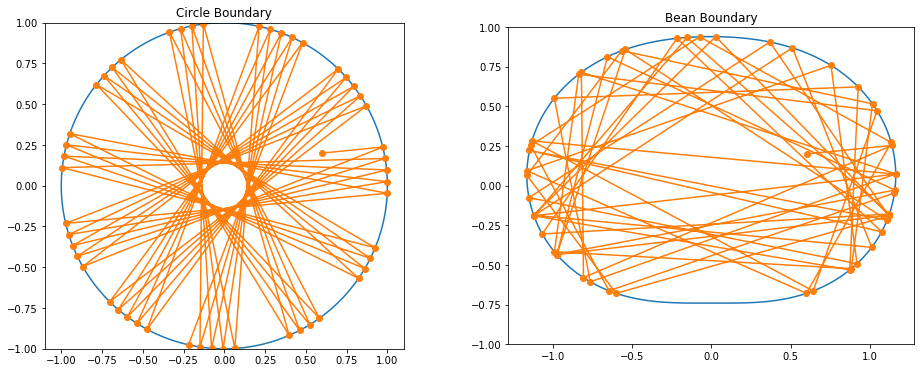

In [6]:
r0 = np.array([0.6, 0.2])
theta = 0.1
v0 = np.array([np.cos(theta), np.sin(theta)])

compare_traj_for_bdys(bdys, 50, r0, v0)

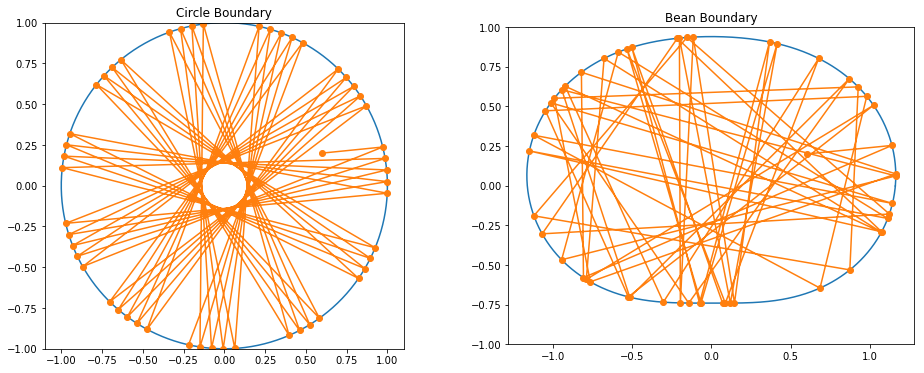

In [7]:
r0 = np.array([0.6, 0.2000001])
theta = 0.1
v0 = np.array([np.cos(theta), np.sin(theta)])

compare_traj_for_bdys(bdys, 50, r0, v0)

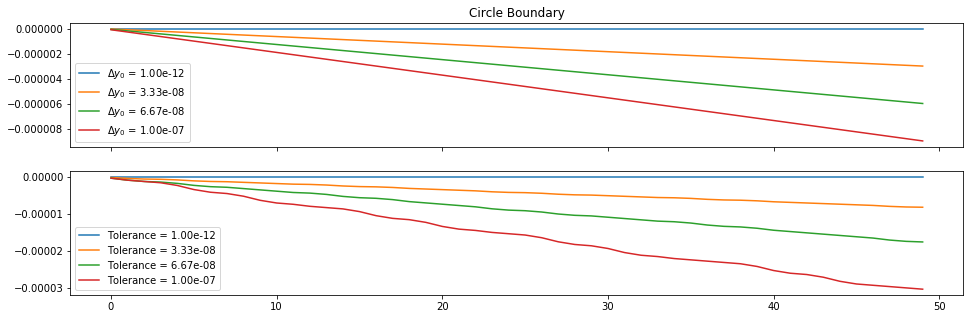

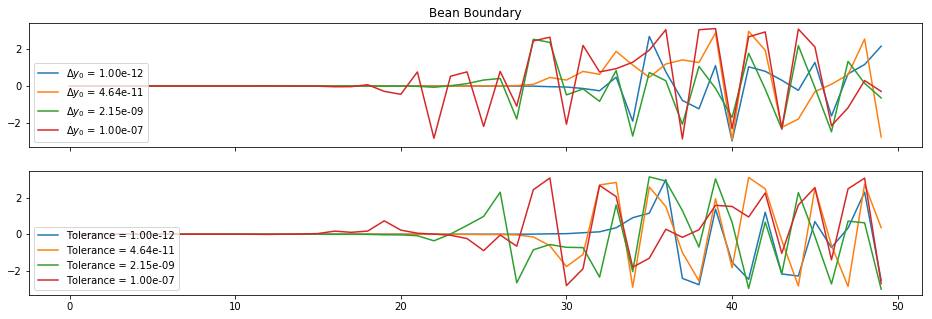

In [18]:
r0 = np.array([0.6, 0.2])
theta = 0.1
v0 = np.array([np.cos(theta), np.sin(theta)])
lines = 4

for ref_bdy, dys in ([UnitCircleBoundary(**custom_rf),
                      np.linspace(1e-12, 1e-7, num=lines)],
                     [BeanBoundary(0.16, 0.1, 2.0, 1.0, **custom_rf),
                      1e-12*np.logspace(0, 5, num=lines)]):
    plot_divergence(50, ref_bdy, r0, v0, dys)

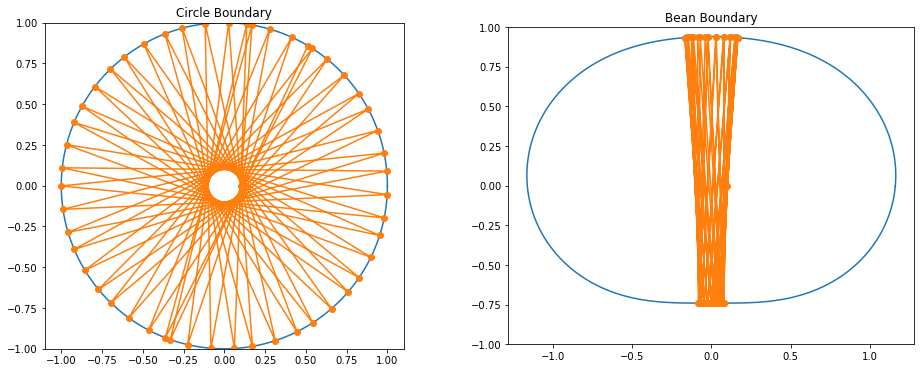

In [9]:
r0 = np.array([0.1, 0])
theta = 1.5
v0 = np.array([np.cos(theta), np.sin(theta)])

compare_traj_for_bdys(bdys, 50, r0, v0)

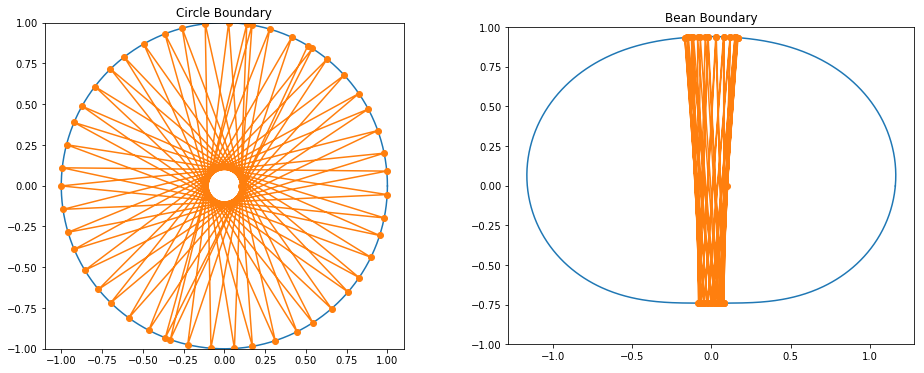

In [10]:
r0 = np.array([0.1, 0.000001])
theta = 1.5
v0 = np.array([np.cos(theta), np.sin(theta)])

compare_traj_for_bdys(bdys, 50, r0, v0)

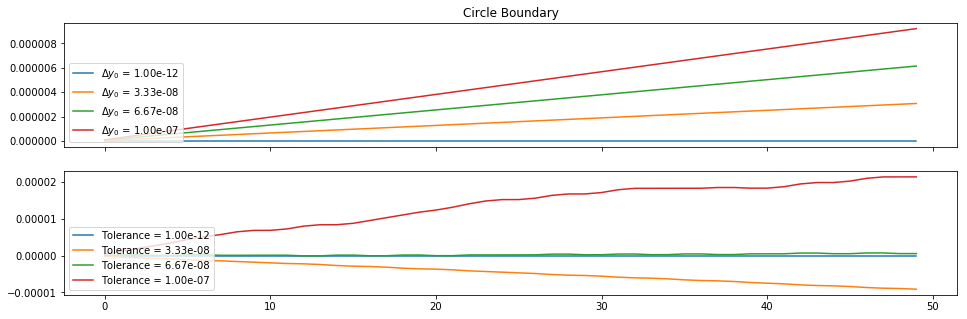

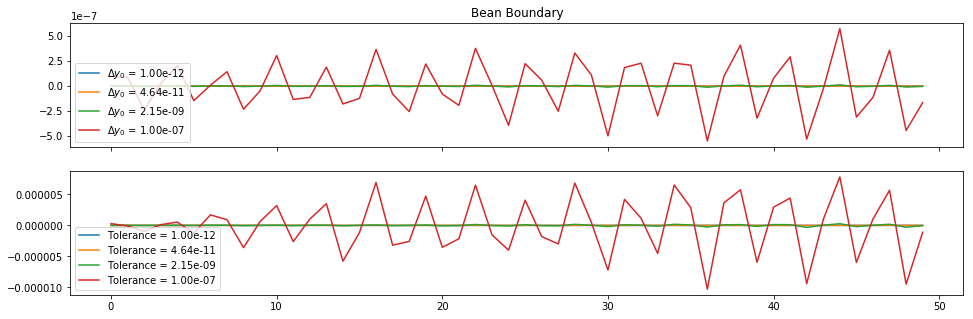

In [20]:
r0 = np.array([0.1, 0])
theta = 1.5
v0 = np.array([np.cos(theta), np.sin(theta)])
lines = 4

for ref_bdy, dys in ([UnitCircleBoundary(**custom_rf),
                      np.linspace(1e-12, 1e-7, num=lines)],
                     [BeanBoundary(0.16, 0.1, 2.0, 1.0, **custom_rf),
                      1e-12*np.logspace(0, 5, num=lines)]):
    plot_divergence(50, ref_bdy, r0, v0, dys)

In [12]:
def compare_poinc_for_bdys(bdys, bounces, ic_list, plotargs):
    """Create side-by-side Poincare sections for the same i.c.'s
        but different boundarys.
    
    Scatters a new plot on the same axis for each (r0, v0) in ic_list.
    """
    fig, axlist = plt.subplots(1, len(bdys), figsize=(16,6))
    for bdy, ax, n_per_ic in zip(bdys, axlist, bounces):
        ax.set_title(str(bdy))
        for [x, y, theta], n in zip(ic_list, n_per_ic):
            r0 = np.array([x, y])
            v0 = np.array([np.cos(theta), np.sin(theta)])
            plotargs['label'] = r'$r_0$={0},    $\theta_0$={1}'\
                                .format(r0, theta)
            state = reset_plots(fig, r0, v0, bdy, n,
                                poinc_ax=ax, clear_poinc_ax=False,
                                **plotargs)
    axlist[0].legend(loc='center')

      converged: False
           flag: 'convergence error'
 function_calls: 102
     iterations: 50
           root: 5.0087874126564547


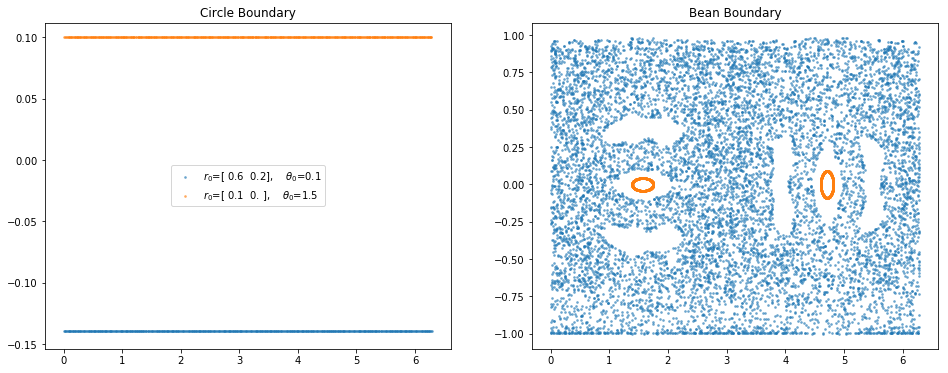

In [13]:
ic_list = [[0.6, 0.2, 0.1], [0.1, 0, 1.5]]
# num bounces per boundary per ic's
bounces = [[500, 500],
           [10000, 1000]]

plotargs = {'s': 3, 'alpha': 0.5}
compare_poinc_for_bdys(bdys, bounces, ic_list, plotargs)

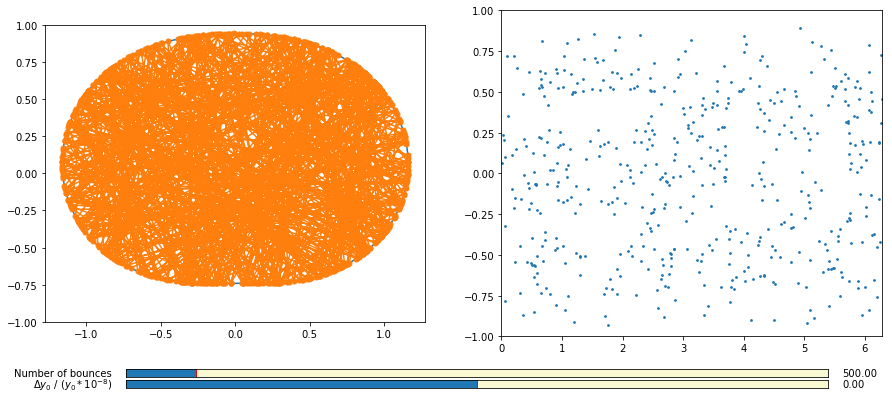

In [23]:
r0 = np.array([0.6, 0.2])
theta = 0.1
# r0 = np.array([0.1, 0])
# theta = 1.5
v0 = np.array([np.cos(theta), np.sin(theta)])
custom_rf['param_rootfind'] = 'bracketing'

# bdy = UnitCircleBoundary(**custom_rf)
bdy = BeanBoundary(0.16, 0.1, 2.0, 1.0, **custom_rf)

bounces = 500
rdy_func = lambda r, dy: r * np.array([1, 1 + dy*1e-8])
deltay = 0
max_bounces = 5000
max_deltay = 50
plotargs = {'s': 3}

fig, axlist = plt.subplots(1, 2, figsize=(15,6))
bdyline = bdy.coords_cart(np.arange(0, 2*np.pi, 0.01))
axlist[0].plot(bdyline[0], bdyline[1])
# Plot empty trajectory line object; I'll send data to it after 
traj_line, = axlist[0].plot([0, 0], [0, 0], 'o-', label='Trajectory',
                            markersize=5)
axlist[0].set_aspect('equal')
axlist[0].set_ylim([-1, 1])
poinc_ax = axlist[1]

# Initialize plotline data
state = reset_plots(fig, rdy_func(r0, deltay), v0, bdy,
                    bounces, traj_line, poinc_ax, **plotargs)

sbounces, sdeltay = make_interactive(fig, state, r0, v0, bdy,
                                     bounces, max_bounces,
                                     deltay, max_deltay, rdy_func,
                                     traj_line, poinc_ax, **plotargs)